https://www.kaggle.com/datasets/msambare/fer2013

# 1. Load Dependency

## 1.1 Load Code from Github

In [ ]:
#rm -rf Data_Mining
!git clone https://github.com/VinceTruong/Data_Mining.git

## 1.2 Load necessaty tools and libraries

In [53]:
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_curve, auc, accuracy_score
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform

from keras.models import Sequential
from keras import regularizers
from keras.layers import AveragePooling2D, Add, Dense, Conv2D, MaxPool2D , Flatten, Dropout, BatchNormalization, Input, ZeroPadding2D, Activation, MaxPooling2D

import warnings
warnings.filterwarnings("ignore")

In [2]:
train_path = "Data_Mining/dataset_aug/train"
test_ds = "Data_Mining/dataset_aug/test"

# 2. Load and explore dataset

## 2.1 General Exploration

In [3]:
os.listdir(train_path) # 7 categories

['happy', 'fear', 'angry', 'surprise', 'sad', 'neutral', 'disgust']

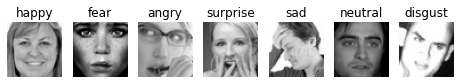

In [4]:
# explore the image and labels
i = 1
plt.figure(figsize=(8,8))
for expression in os.listdir(train_path):
    img = load_img((train_path +'/'+ expression +'/'+ os.listdir(train_path + '/' + expression)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
    
plt.show()

## 2.2 Train - Validation - Test Split

In [5]:
# The data consists of 48x48 pixel grayscale images of faces.
batch_size = 256
img_height = 48
img_width = 48

In [6]:
# Load train, validation, test from directory
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory = train_path,
    labels = "inferred",
    validation_split = 0.2,
    subset = 'training',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='grayscale',
    label_mode="categorical")

val_ds = tf.keras.utils.image_dataset_from_directory(
    directory = train_path,
    labels = "inferred",
    validation_split = 0.2,
    subset = 'validation',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='grayscale',
    label_mode="categorical")

test_ds = tf.keras.utils.image_dataset_from_directory(
    directory = test_ds,
    labels = "inferred",
    seed=123,
    image_size=(img_height, img_width),
    #batch_size=batch_size,
    color_mode='grayscale',
    label_mode="categorical")

Found 31970 files belonging to 7 classes.
Using 25576 files for training.


2022-12-05 09:51:05.599027: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-05 09:51:05.599969: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-05 09:51:05.601475: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-05 09:51:05.602299: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-05 09:51:05.603110: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Found 31970 files belonging to 7 classes.
Using 6394 files for validation.
Found 7101 files belonging to 7 classes.


## 2.3 Normalize dataset

In [58]:
train_ds_normal = train_ds.map(lambda x,y: (x/255, y))
val_ds_normal = val_ds.map(lambda x,y: (x/255, y))
test_ds_normal = test_ds.map(lambda x,y: (x/255, y))

In [7]:
#train dataset
trainX, trainY = zip(*train_ds)
trainX = np.concatenate([x for x in trainX], axis = 0)
trainY = np.concatenate([y for y in trainY], axis = 0)
#validation dataset
valX, valY = tuple(zip(*val_ds))
valX = np.concatenate([x for x in valX], axis = 0)
valY = np.concatenate([y for y in valY], axis = 0)
#test datasett
testX, testY = tuple(zip(*test_ds))
testX = np.concatenate([x for x in testX], axis = 0)
testY = np.concatenate([y for y in testY], axis = 0)

2022-12-05 09:51:09.697089: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [8]:
print(trainX.shape)
print(trainY.shape)

print(valX.shape)
print(valY.shape)

print(testX.shape)
print(testY.shape)

(25576, 48, 48, 1)
(25576, 7)
(6394, 48, 48, 1)
(6394, 7)
(7101, 48, 48, 1)
(7101, 7)


happy


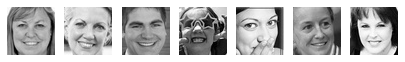

fear


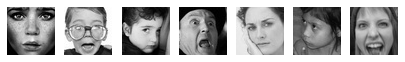

angry


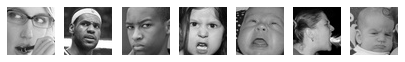

surprise


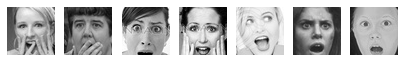

sad


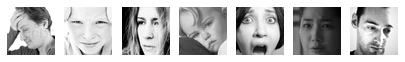

neutral


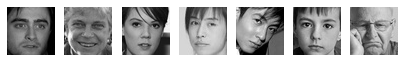

disgust


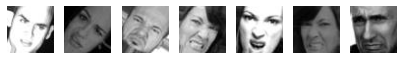

In [9]:
# Explore 7 data samples for each category
i = 1
for expression in os.listdir(train_path):
    plt.figure(figsize=(7,7))
    print(expression)
    for j in range(1, 8):
        img = load_img((train_path +'/'+ expression +'/'+ os.listdir(train_path + '/' + expression)[j]))
        plt.subplot(i,7,j)
        plt.imshow(img)
        plt.axis('off')
    i += 1
    plt.show()

## 2.4 Visualisation

In [108]:
train_category = list(np.sum(trainY, axis=0).astype('int64'))
print(train_category)

[3188, 3098, 3276, 5716, 3924, 3857, 2517]


In [109]:
test_category = list(np.sum(testY, axis=0).astype('int64'))
print(test_category)

[944, 108, 1007, 1759, 1223, 1234, 826]


In [112]:
train_category.sort(reverse=True)
facial = ['happy', 'neutral', 'sad', 'fear', 'angry', 'disgust','surprise']

#print(category)
dic_train = {facial[i]: train_category[i] for i in range(7)}
print(dic_train)

{'happy': 5716, 'neutral': 3924, 'sad': 3857, 'fear': 3276, 'angry': 3188, 'disgust': 3098, 'surprise': 2517}


In [111]:
test_category.sort(reverse=True)

#print(category)
dic_test = {facial[i]: test_category[i] for i in range(7)}
print(dic_test)

{'happy': 1759, 'neutral': 1234, 'sad': 1223, 'fear': 1007, 'angry': 944, 'disgust': 826, 'surprise': 108}


In [113]:
#Training set
fig = go.Figure(data=[go.Bar(x=list(dic_train.keys()), 
                              y=list(dic_train.values()))])
fig

In [15]:
#Test set
fig = go.Figure(data=[go.Bar(x=list(dic_test.keys()), 
                              y=list(dic_test.values()))])
fig

# 3. Model Experiment


## 3.1 Define some Plot functions

In [16]:
y_test = np.argmax(testY, axis = 1)

In [17]:
args = {
    "epochs": 20,
    "batches": 256,
    "lr": 0.0001
}
adm = Adam(learning_rate=args["lr"])

In [40]:
# roc_curve definition
def plot_multiclass_roc(y_predict, y_test):

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    
    for i in range(7):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_predict[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=(10,10))
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(7):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %s' % (roc_auc[i], test_ds.class_names[i]))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

#plot_multiclass_roc()

In [81]:
# confustion matrix for model result
def plot_confusion_matrix(actual, predicted, labels, ds_type):
    cm = tf.math.confusion_matrix(actual, predicted)
    ax = sns.heatmap(cm, annot=True, fmt='g', cmap = 'Blues')
    sns.set(rc={'figure.figsize':(10, 10)})
    sns.set(font_scale=1.4)
    ax.set_title('Confusion matrix of action recognition for ' + ds_type)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0) 
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)
    
labels = ['angry', 'digust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

## 3.2 Alex Net

Epoch 1/20
100/100 [==============================] - 31s 295ms/step - loss: 2.3437 - accuracy: 0.2668 - val_loss: 2.3666 - val_accuracy: 0.1221
Epoch 2/20
100/100 [==============================] - 31s 302ms/step - loss: 1.6317 - accuracy: 0.3767 - val_loss: 3.0160 - val_accuracy: 0.1221
Epoch 3/20
100/100 [==============================] - 30s 301ms/step - loss: 1.4952 - accuracy: 0.4320 - val_loss: 4.0479 - val_accuracy: 0.1221
Epoch 4/20
100/100 [==============================] - 31s 305ms/step - loss: 1.3862 - accuracy: 0.4744 - val_loss: 5.0567 - val_accuracy: 0.1221
Epoch 5/20
100/100 [==============================] - 30s 300ms/step - loss: 1.2840 - accuracy: 0.5116 - val_loss: 4.7142 - val_accuracy: 0.1306
Epoch 6/20
100/100 [==============================] - 30s 301ms/step - loss: 1.2067 - accuracy: 0.5460 - val_loss: 3.1553 - val_accuracy: 0.2122
Epoch 7/20
100/100 [==============================] - 31s 304ms/step - loss: 1.1273 - accuracy: 0.5773 - val_loss: 1.6323 - val_ac

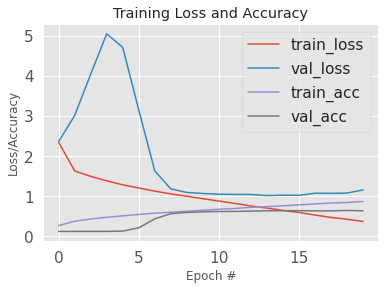

In [59]:
#AlexNet
def process_images(image,label):
    # Normalize images to have a mean of 0 and standard deviation of 1
    image = tf.image.per_image_standardization(image)
    # Resize images from 48x48 to 277x277
    image = tf.image.resize(image, (227,227))
    return image,label

train_alex = train_ds_normal.map(process_images)
                    

val_alex =val_ds_normal.map(process_images)
                

test_alex = test_ds_normal.map(process_images)
               

AlexNet = Sequential()
AlexNet.add(Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,1)))
AlexNet.add(BatchNormalization())
AlexNet.add(MaxPool2D(pool_size=(3,3), strides=(2,2)))
AlexNet.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"))
AlexNet.add(BatchNormalization())
AlexNet.add(MaxPool2D(pool_size=(3,3), strides=(2,2)))
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"))
AlexNet.add(BatchNormalization())
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"))
AlexNet.add(BatchNormalization())
AlexNet.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"))
AlexNet.add(BatchNormalization())
AlexNet.add(MaxPool2D(pool_size=(3,3), strides=(2,2)))
AlexNet.add(Flatten())
AlexNet.add(Dense(4096, activation='relu'))
AlexNet.add(Dropout(0.5))
AlexNet.add(Dense(4096, activation='relu'))
AlexNet.add(Dropout(0.5))
AlexNet.add(Dense(7, activation='softmax'))
#AlexNet.summary()

AlexNet.compile(optimizer=adm, loss='categorical_crossentropy', metrics=['accuracy'])
AlexNethistory = AlexNet.fit(train_alex, epochs=args["epochs"], batch_size=args["batches"],validation_data=val_alex)

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, args["epochs"]), AlexNethistory.history["loss"], label="train_loss")
plt.plot(np.arange(0, args["epochs"]), AlexNethistory.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, args["epochs"]), AlexNethistory.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, args["epochs"]), AlexNethistory.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

In [114]:
y_predict_alex = AlexNet.predict(test_alex)
y_predict_alex_label = np.argmax(y_predict_alex, axis = 1)

In [115]:
accuracy_score(y_test, y_predict_alex_label)

0.17631319532460216

In [116]:
print(classification_report(y_test,y_predict_alex_label, target_names=labels))

              precision    recall  f1-score   support

       angry       0.13      0.11      0.12       944
      digust       0.02      0.05      0.03       108
        fear       0.14      0.14      0.14      1007
       happy       0.25      0.24      0.24      1759
     neutral       0.20      0.17      0.18      1223
         sad       0.18      0.24      0.21      1234
    surprise       0.12      0.11      0.11       826

    accuracy                           0.18      7101
   macro avg       0.15      0.15      0.15      7101
weighted avg       0.18      0.18      0.18      7101



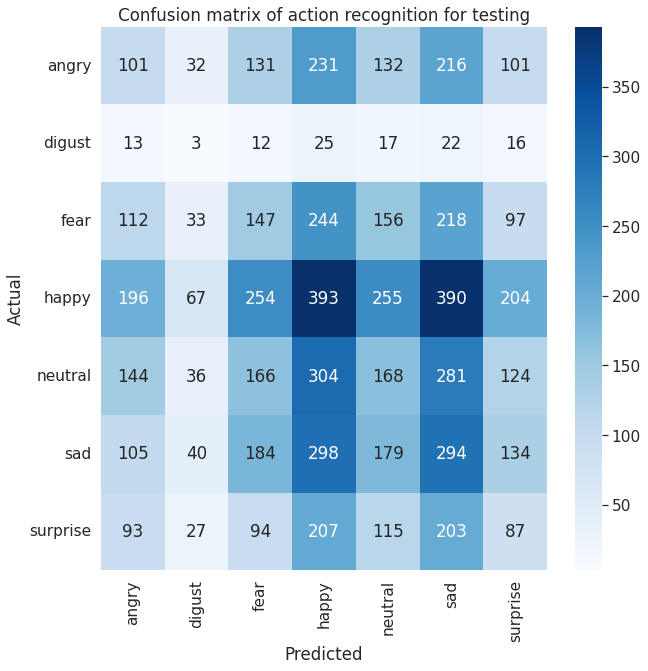

In [100]:
plot_confusion_matrix(y_test, y_predict_alex_label, labels, 'testing')

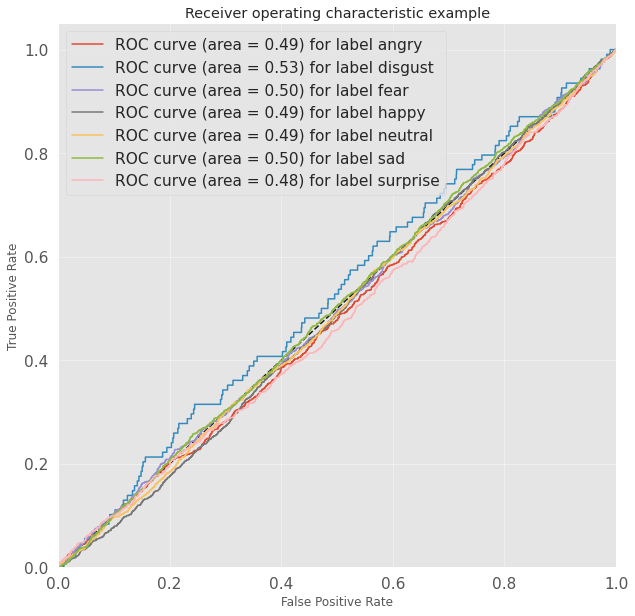

In [94]:
plot_multiclass_roc(y_predict_alex, testY)

## 3.3 VGG16

VGG16 is convolutional neutral network introduced by K. Simonyan and A. Zisserman, who won a ILSVR(Imagenet) competition in 2014. 

Instead of using large number of hyper-parameter, it feature is using convolution layer of 3x3 filter with stride 1 and same padding, along with maxpool layer of 2x2 filter of stride 2.  

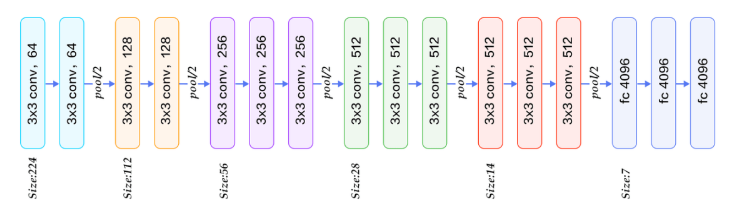

In [117]:
# Creating model
VGG = Sequential()

# 2 x convolution layer of 64 filters of size 3x3  +  1 x maxpool layer 2x2
VGG.add(Conv2D(input_shape=((48, 48, 1)),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
VGG.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
VGG.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))


# 2 x convolution layer of 128 filters of size 3x3  +  1 x maxpool layer 2x2
VGG.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
VGG.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
VGG.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))


# 3 x convolution layer of 256 filters of size 3x3  +  1 x maxpool layer 2x2
VGG.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
VGG.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
VGG.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
VGG.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))


# 3 x convolution layer of 512 filters of size 3x3  +  1 x maxpool layer 2x2
VGG.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
VGG.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
VGG.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
VGG.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))


# 3 x convolution layer of 512 filters of size 3x3  +  1 x maxpool layer 2x2
VGG.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
VGG.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
VGG.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
VGG.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))


# After several convolution layers and pooling layer, data has been flatten and loaded into fully connected layer
# 2 x Dense layers of 4096 units  +  1 x Dense Softmax layer of 7 units
VGG.add(Flatten())
VGG.add(Dense(units=4096,activation="relu"))
VGG.add(Dense(units=4096,activation="relu"))
VGG.add(Dense(units=7, activation="softmax"))

In [118]:
VGG.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 48, 48, 64)        640       
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 48, 48, 64)        36928     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 24, 24, 128)       73856     
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 24, 24, 128)       147584    
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 12, 12, 128)       0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 12, 12, 256)      

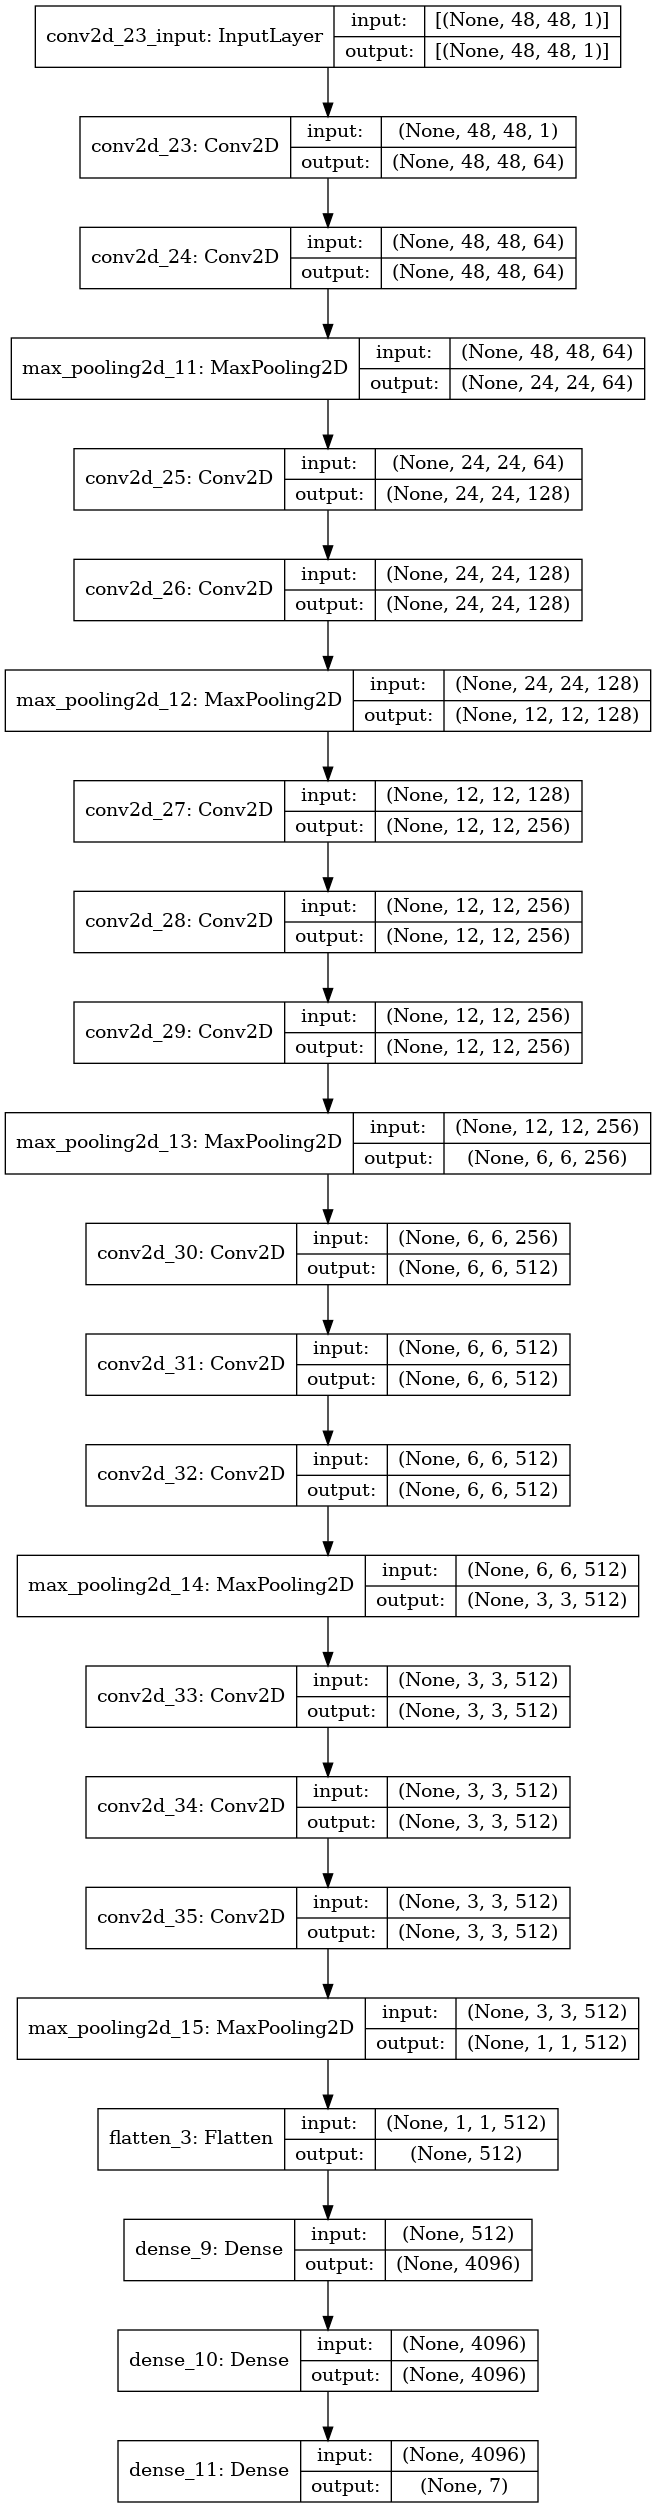

In [119]:
plot_model(VGG, show_shapes=True, show_layer_names=True)

In [121]:
# Saving Checkpoint 
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1))

check_point = ModelCheckpoint(filepath='VGG.hdf5', monitor='val_loss', save_best_only=True)

early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

callbacks = [reduce_lr, check_point, early_stop]


[INFO] training network...
Epoch 1/20
100/100 [==============================] - 21s 205ms/step - loss: 1.8556 - accuracy: 0.2565 - val_loss: 1.9165 - val_accuracy: 0.2853
Epoch 2/20
100/100 [==============================] - 21s 208ms/step - loss: 1.6075 - accuracy: 0.3866 - val_loss: 1.4539 - val_accuracy: 0.4528
Epoch 3/20
100/100 [==============================] - 21s 213ms/step - loss: 1.3901 - accuracy: 0.4727 - val_loss: 1.3066 - val_accuracy: 0.5133
Epoch 4/20
100/100 [==============================] - 21s 208ms/step - loss: 1.2316 - accuracy: 0.5343 - val_loss: 1.2467 - val_accuracy: 0.5324
Epoch 5/20
100/100 [==============================] - 21s 207ms/step - loss: 1.1003 - accuracy: 0.5877 - val_loss: 1.2073 - val_accuracy: 0.5474
Epoch 6/20
100/100 [==============================] - 21s 209ms/step - loss: 0.9557 - accuracy: 0.6399 - val_loss: 1.1639 - val_accuracy: 0.5668
Epoch 7/20
100/100 [==============================] - 21s 210ms/step - loss: 0.8324 - accuracy: 0.6867 

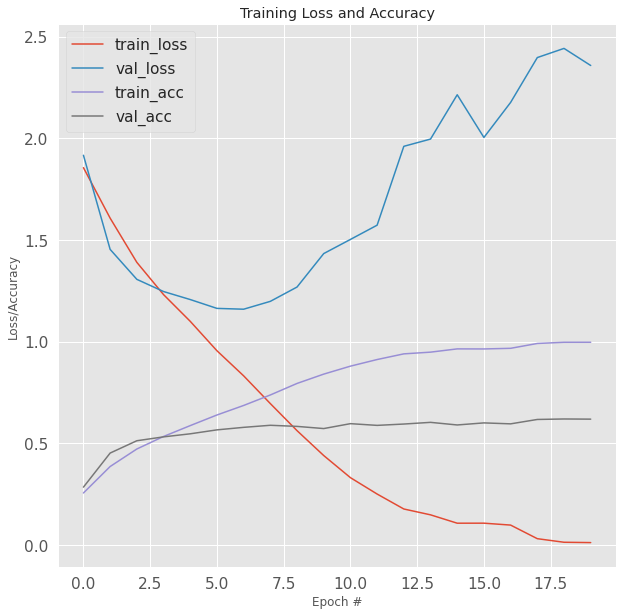

In [122]:
# timing the training process
tic = time.perf_counter()    # start timer
# train the model using SGD
print("[INFO] training network...")
sgd = SGD(learning_rate=args["lr"], momentum=0.9, nesterov=True)
adm = Adam(learning_rate=args["lr"])
VGG.compile(loss="categorical_crossentropy", optimizer=adm, metrics=["accuracy"])

H = VGG.fit(x = trainX, y= trainY, validation_data=(valX, valY), epochs=args["epochs"], batch_size=args["batches"], callbacks=callbacks)

toc = time.perf_counter()    # stop timer
print(f"\n[INFO] Training completed in {(toc - tic)/60:0.4f} minutes\n")


# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, args["epochs"]), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, args["epochs"]), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, args["epochs"]), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, args["epochs"]), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
# plt.savefig(args["output"])

In [127]:
y_predict_vgg = VGG.predict(testX)
y_predict_vgg_label = np.argmax(y_predict_vgg, axis = 1)

In [128]:
accuracy_score(y_test, y_predict_vgg_label)

0.574566962399662

In [129]:
print(classification_report(y_test, y_predict_vgg_label, target_names = labels))

              precision    recall  f1-score   support

       angry       0.52      0.43      0.47       944
      digust       0.35      0.56      0.43       108
        fear       0.41      0.45      0.43      1007
       happy       0.78      0.78      0.78      1759
     neutral       0.52      0.52      0.52      1223
         sad       0.43      0.49      0.46      1234
    surprise       0.84      0.66      0.74       826

    accuracy                           0.57      7101
   macro avg       0.55      0.56      0.55      7101
weighted avg       0.59      0.57      0.58      7101



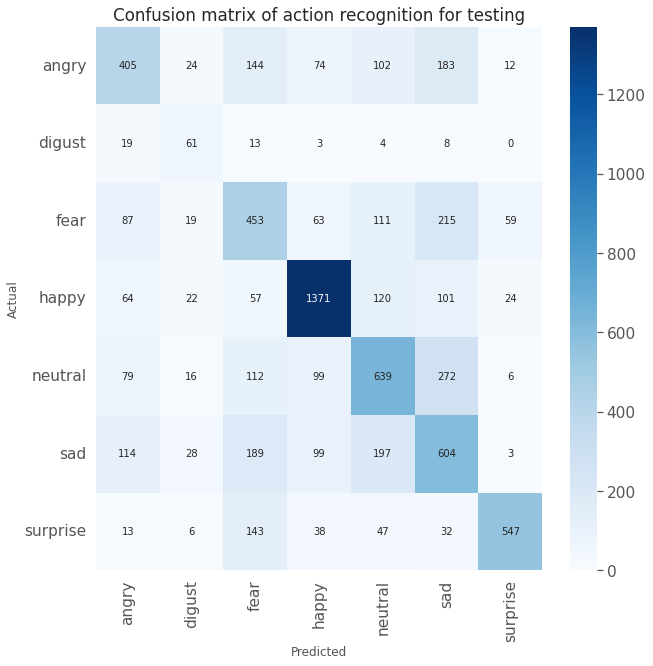

In [130]:
plot_confusion_matrix(y_test, y_predict_vgg_label, labels, 'testing')

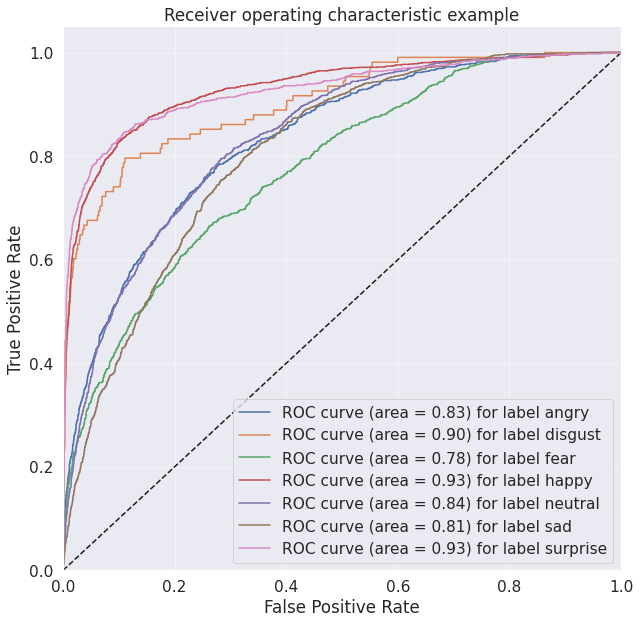

In [131]:
plot_multiclass_roc(y_predict_vgg, testY)

# 4. Conclusion

After training two models, we can infer that:
- AlexNet Model: high accuracy on training and validation set, but low accuracy, F1 score on test set (as shown in classification report, ROC curve and confusion matrix)
- VGG16 Model: though performing very well on training set (0.99 accurracy), it is overfitting on validation set (the more epoches, the more loss value is). However, its performance on test set is acceptable since F1 score and accuracy are higher than that of other two models.  